In [323]:
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET

import pandas as pd
from shapely.geometry import Point
import os
from sklearn.preprocessing import PolynomialFeatures

import matsim
import pandas as pd
from collections import defaultdict

from shapely.geometry import box
import logging
import calendar
import datetime

import ast

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [93]:

# ==============================================================================
# 📦 DATA LOADING: Street networks and parcel shipment data (DHL, Hermes)
# ------------------------------------------------------------------------------

logging.info("Reading input data...")

# Define coordinate reference system (ETRS89 / UTM zone 32N)
crs = 25832

# Input folder path
folder = "input/"

# File names
matsim_network_xml_file = "multimodalNetwork.xml"           # MATSim network file (XML)
dhl_streets_file = "dhl2streets_2021.shp"                   # DHL street segments with daily volume
hermes_file = "Hermes_PLZ-Menge_2019-2021.csv"              # Hermes PLZ-level volume

# -------------------------------------------------------------------------------
# 1. Load MATSim street network and convert to GeoDataFrame
# -------------------------------------------------------------------------------
matsim_gdf = matsim.read_network(folder + matsim_network_xml_file).as_geo()

# -------------------------------------------------------------------------------
# 2. Load DHL street segments (Shapefile), reproject and rename daily volume column
# -------------------------------------------------------------------------------

# Liste der Sonderstraßen (z. B. Lager)
special_streets = ["Am Berkhopsfeld", "Stockholmer Allee"]
dhl_streets_gdf = gpd.read_file(folder + dhl_streets_file, encoding='UTF-8')
dhl_streets_gdf = dhl_streets_gdf.to_crs(crs)
dhl_streets_gdf = dhl_streets_gdf.rename(columns={'tagesschni': 'dhl_tag'})  # 'dhl_tag' = daily DHL volume
dhl_streets_gdf = dhl_streets_gdf[~dhl_streets_gdf["name"].isin(special_streets)]

# -------------------------------------------------------------------------------
# 3. Load Hermes PLZ-level shipment data and estimate daily volume for 2021
# -------------------------------------------------------------------------------
hermes_df = pd.read_csv(folder + hermes_file, encoding='utf-8', sep=';', thousands='.')

# Estimate 2021 volume using 2020 + 8/12 of the delta from 2020 to 2021
# Why 8/12? → Based on assuming 8 months of 2021 data are observed
# Why divide by 26? → Normalization to average shipments per weekday (≈ 26 delivery weeks)
hermes_df['hermes_tag'] = round(
    (hermes_df['2020'] + (8 / 12) * (hermes_df['2021'] - hermes_df['2020'])) / 26
)

logging.info("Finished reading DHL and Hermes input data.")



2025-04-04 19:42:10,702 - INFO - Reading input data...
2025-04-04 19:44:46,862 - INFO - Finished reading DHL and Hermes input data.


In [299]:
df_b2b_share = pd.read_csv("output/01_b2b_forecast_complete.csv")

weekly_forecast_ci_df = pd.read_csv("output/03_yearly_weekly_parcel_forecast.csv")
weekly_forecast_ci_df["Date"] = pd.to_datetime(weekly_forecast_ci_df["Date"])

ga_corrected_b2b_gdf = gpd.read_file("output/05_ga_corrected_b2b_with_marked_adjust_gdf.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
#Convert Columns with Numeric-looking Strings to Proper Numeric Format
# Convert 'object'-type columns to numeric if possible
for col in ga_corrected_b2b_gdf.select_dtypes(include=["object"]).columns:
    if col.startswith("market_shares_"):
        # Try to parse as dictionary
        ga_corrected_b2b_gdf[col] = ga_corrected_b2b_gdf[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
    elif col != "geometry":  # avoid geometry column
        try:
            converted = pd.to_numeric(ga_corrected_b2b_gdf[col], errors="coerce")
            if converted.notna().sum() > 0.9 * len(ga_corrected_b2b_gdf):
                ga_corrected_b2b_gdf[col] = converted
        except Exception as e:
            print(f"Skipping column {col} due to error: {e}")
            pass

df_b2b_by_year = pd.read_csv("output/05_optimized_b2b_shares_by_year.csv")



In [31]:
def get_english_weekday_name(date):
    """
    Converts a German weekday name (in a given datetime object) to its English equivalent.

    Parameters:
    -----------
    date : datetime.date or datetime.datetime
        A date object from which the weekday will be extracted and translated.

    Returns:
    --------
    english_name : str
        English weekday name (e.g., "Monday", "Tuesday", ...).
        If the weekday is already in English or not found in the mapping,
        it is returned as-is.
    """

    # Extract the weekday name from the date (in the system's locale)
    weekday_raw = date.strftime("%A")

    # German to English weekday mapping
    de_to_en = {
        "Montag": "Monday",
        "Dienstag": "Tuesday",
        "Mittwoch": "Wednesday",
        "Donnerstag": "Thursday",
        "Freitag": "Friday",
        "Samstag": "Saturday",
        "Sonntag": "Sunday"
    }

    # Return the translated name if found, otherwise return original
    return de_to_en.get(weekday_raw, weekday_raw)


def get_relative_package_change(target_date, weekly_forecast_ci_df, model="linear"):
    """
    Computes the relative change in parcel volume for a given week and year,
    compared to a fixed reference week (week 20 of 2021), based on the selected forecast model.

    Parameters:
    -----------
    target_date : datetime.date or datetime.datetime
        The target date for which the relative change is calculated.
        Only the ISO week and year will be used.

    weekly_forecast_ci_df : pd.DataFrame
        DataFrame containing weekly forecast values.
        Must contain columns: 'Date', 'Year', and forecast columns like 'linear_Prognose', etc.

    model : str
        Forecast model to use: one of ['linear', 'logistic', 'exponential'].

    Returns:
    --------
    relative_change : float
        Ratio of the target week's forecast value to the reference value
        from week 20 of the year 2021.

    Raises:
    -------
    ValueError if forecast data is missing or model name is invalid.
    """

    year = target_date.year
    target_week = target_date.isocalendar().week
    ref_week = 20
    ref_year = 2021

    # Filter forecast value for the target year/week
    target_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Year"] == year) &
        (weekly_forecast_ci_df["Date"].dt.isocalendar().week == target_week)
    ]

    if target_week_data.empty:
        raise ValueError(f"No forecast data found for year {year}, week {target_week}.")

    # Reference forecast: Week 20 of 2021
    ref_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Year"] == ref_year) &
        (weekly_forecast_ci_df["Date"].dt.isocalendar().week == ref_week)
    ]

    if ref_week_data.empty:
        raise ValueError("No forecast data found for reference week 20 of 2021.")

    # Select model column
    if model == "linear":
        target_value = target_week_data["linear_Prognose"].values[0]
        ref_value = ref_week_data["linear_Prognose"].values[0]
    elif model == "logistic":
        target_value = target_week_data["logistic_Prognose"].values[0]
        ref_value = ref_week_data["logistic_Prognose"].values[0]
    elif model == "exponential":
        target_value = target_week_data["exponential_Prognose"].values[0]
        ref_value = ref_week_data["exponential_Prognose"].values[0]
    else:
        raise ValueError("Invalid model type. Choose from 'linear', 'logistic', or 'exponential'.")

    # Compute relative change
    relative_change = target_value / ref_value

    # Logging for traceability
    logging.info(
        f"[{target_date}] Model: {model}, Target Year: {year}, ISO Week: {target_week}, "
        f"Reference Year: {ref_year}, Week: {ref_week}, "
        f"Target Value: {target_value:.4f}, Reference Value: {ref_value:.4f}, "
        f"→ Relative Weekly Factor: {relative_change:.4f}"
    )

    return relative_change



def get_relative_package_change_per_day(
    target_date,
    weekly_forecast_ci_df,
    model="linear",
    weekday_distribution=None
):
    """
    Computes the expected relative change in parcel volume for a specific date,
    taking into account both:
        - The long-term weekly growth or shrinkage (based on the selected forecast model), and
        - The typical weekday-level distribution of parcels across the delivery week.

    Parameters:
    -----------
    target_date : datetime.date or datetime.datetime
        The delivery date for which the adjustment factor is computed.

    weekly_forecast_ci_df : pd.DataFrame
        DataFrame with forecast values per week (must include 'Date', 'Year', and columns like 'linear_Prognose').

    model : str, default = "linear"
        Forecast model to use. Must be one of: ['linear', 'logistic', 'exponential'].

    weekday_distribution : dict, optional
        Optional dictionary specifying the average weekday parcel distribution.
        Keys should be English weekday names (e.g., "Monday"), and values should sum to 1.0.
        If not provided, a default distribution is used.

    Returns:
    --------
    daily_relative_change : float
        The relative adjustment factor for the given delivery day (compared to week 20 of 2021).

    Raises:
    -------
    ValueError
        If the weekday is not valid or data is missing.
    """

    # --- Default weekday share (empirical distribution)
    default_distribution = {
        "Monday":    0.16,
        "Tuesday":   0.19,
        "Wednesday": 0.18,
        "Thursday":  0.17,
        "Friday":    0.15,
        "Saturday":  0.10
    }

    # Use user-supplied distribution or fall back to default
    distribution = weekday_distribution or default_distribution

    # Determine the weekday name in English (e.g., 'Monday')
    weekday_name = get_english_weekday_name(target_date)

    # Safety check
    if weekday_name not in distribution:
        raise ValueError(f"'{weekday_name}' is not a valid weekday key in the distribution.")

    # --- Step 1: Get relative change for the entire week
    weekly_relative_change = get_relative_package_change(
        target_date=target_date,
        weekly_forecast_ci_df=weekly_forecast_ci_df,
        model=model
    )

    # --- Step 2: Weekday-specific volume share
    day_share = distribution[weekday_name]

    # --- Step 3: Number of delivery days (typically 6)
    num_delivery_days = len(distribution)

    # --- Step 4: Average share if distributed evenly across delivery days
    average_day_share = 1 / num_delivery_days

    # --- Step 5: Adjust weekday's share relative to the average (e.g., Tuesday gets +14% more if 0.19 vs 0.166...)
    day_multiplier = day_share / average_day_share

    # --- Step 6: Final daily multiplier = weekly trend * weekday bias
    daily_relative_change = weekly_relative_change * day_multiplier

    # Logging
    logging.info(
        f"[{target_date}] Model: {model}, ISO Week: {target_date.isocalendar().week}, "
        f"Weekday: {weekday_name}, Weekly growth factor: {weekly_relative_change:.4f}, "
        f"Weekday share: {day_share:.2f}, Relative weekday multiplier: {day_multiplier:.4f}, "
        f"→ Final daily factor (vs. 2021 baseline): {daily_relative_change:.4f}"
    )

    return daily_relative_change


In [317]:
from collections import defaultdict
import pandas as pd

def analyze_weighted_market_shares(gdf, year, volume_col="total_coun", plz_col="postal_cod"):
    """
    Calculates weighted market shares globally and per postal code area.

    Parameters:
    -----------
    gdf : GeoDataFrame or DataFrame
        Input data containing per-cell market share dicts and volume.
    year : int
        The year used to locate the correct market share column.
    volume_col : str
        Column name for total parcel volume per cell.
    plz_col : str
        Column name for postal code.
    
    Returns:
    --------
    global_shares : dict
        Weighted average market shares across all cells.
    df_plz_shares : DataFrame
        Weighted market shares per postal code.
    """
    column_name = f"market_shares_{year}"
    
    if column_name not in gdf.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")
    
    # Infer carrier names from the first valid dict entry
    first_entry = gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    carriers = list(first_entry.keys())

    # Initialize aggregation containers
    carrier_totals = defaultdict(float)
    plz_totals = defaultdict(lambda: {"volume": 0.0, "carriers": defaultdict(float)})

    # Loop over all rows
    for _, row in gdf.iterrows():
        market_shares = row[column_name]
        total_count = row[volume_col]
        plz = row[plz_col]

        if not isinstance(market_shares, dict) or total_count == 0:
            continue

        for carrier, share in market_shares.items():
            volume = share * total_count
            carrier_totals[carrier] += volume
            plz_totals[plz]["carriers"][carrier] += volume
        plz_totals[plz]["volume"] += total_count

    # Global market shares
    total_volume_all = sum(carrier_totals.values())
    global_shares = {
        carrier: round(vol / total_volume_all, 4)
        for carrier, vol in carrier_totals.items()
    }

    # Market shares per PLZ
    plz_rows = []
    for plz, data in plz_totals.items():
        total = data["volume"]
        if total == 0:
            continue
        row = {plz_col: plz}
        for carrier in carriers:
            vol = data["carriers"][carrier]
            row[f"{carrier}_share"] = round(vol / total, 4)
        plz_rows.append(row)

    df_plz_shares = pd.DataFrame(plz_rows)
    return global_shares, df_plz_shares


In [ ]:
def log_global_parcel_summary(
    gdf: pd.DataFrame,
    parcel_df: pd.DataFrame,
    year: int,
    share_column_template: str = "market_shares_{year}"
):
    """
    Logs global parcel B2B/B2C summary and market shares per carrier.

    Parameters:
    -----------
    gdf : pd.DataFrame
        GeoDataFrame with market share dicts for carrier extraction.
    parcel_df : pd.DataFrame
        DataFrame with per-carrier _parcels, _B2B, and _B2C columns.
    year : int
        Simulation year.
    share_column_template : str
        Format string to locate the market share dict column.
    """

    # Infer carrier names from the first dict entry
    column_name = share_column_template.format(year=year)
    if column_name not in gdf.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")

    first_entry = gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    
    carriers = list(first_entry.keys())

    # Sum B2B/B2C volumes
    total_b2b = sum(parcel_df.get(f"{c}_B2B", pd.Series(dtype=float)).sum() for c in carriers)
    total_b2c = sum(parcel_df.get(f"{c}_B2C", pd.Series(dtype=float)).sum() for c in carriers)
    total_parcels = total_b2b + total_b2c

    if total_parcels == 0:
        logging.warning("No parcels found in data.")
        return

    b2b_ratio = round(total_b2b / total_parcels, 4)
    b2c_ratio = round(total_b2c / total_parcels, 4)

    logging.info(f"📦 Global Parcel Distribution for {year}:")
    logging.info(f"  B2B Parcels: {int(total_b2b):,}  ({b2b_ratio:.2%})")
    logging.info(f"  B2C Parcels: {int(total_b2c):,}  ({b2c_ratio:.2%})")
    logging.info(f"  Total:       {int(total_parcels):,}")

    # Carrier market shares
    logging.info("📊 Global Market Share per Carrier:")
    for carrier in carriers:
        parcel_col = f"{carrier}_parcels"
        if parcel_col in parcel_df.columns:
            total = parcel_df[parcel_col].sum()
            share = total / total_parcels
            logging.info(f"  {carrier:<12}: {share:.2%}")
        else:
            logging.info(f"  {carrier:<12}: 0.00% (no data)")


def split_b2b_b2c_to_target(df, parcel_col, b2b_share, b2b_col, b2c_col):
    total_parcels = df[parcel_col].sum()
    target_b2b_sum = int(round(total_parcels * b2b_share))

    # B2B gerundet verteilen, Summe bleibt erhalten
    proportional = df[parcel_col] * b2b_share
    floored = np.floor(proportional).astype(int)
    remainder = proportional - floored

    adjustment_needed = target_b2b_sum - floored.sum()
    if adjustment_needed > 0:
        indices = np.argsort(-remainder)
        floored.iloc[indices[:adjustment_needed]] += 1

    df[b2b_col] = floored
    df[b2c_col] = df[parcel_col] - df[b2b_col]

from scipy.optimize import minimize_scalar

def apply_scaled_b2b_split(df, carriers, b2b_lookup, alpha):
    for carrier in carriers:
        parcel_col = f"{carrier}_parcels"
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"
        if parcel_col in df.columns and carrier in b2b_lookup:
            scaled_share = b2b_lookup[carrier] * alpha
            split_b2b_b2c_to_target(
                df,
                parcel_col=parcel_col,
                b2b_share=scaled_share,
                b2b_col=b2b_col,
                b2c_col=b2c_col
            )

def compute_actual_b2b_ratio(df, carriers):
    total_b2b = sum(df[f"{c}_B2B"].sum() for c in carriers if f"{c}_B2B" in df.columns)
    total_b2c = sum(df[f"{c}_B2C"].sum() for c in carriers if f"{c}_B2C" in df.columns)
    total = total_b2b + total_b2c
    return total_b2b / total if total > 0 else 0

def optimize_b2b_alpha(df, carriers, b2b_lookup, target_b2b):
    def objective(alpha):
        temp = df.copy()
        apply_scaled_b2b_split(temp, carriers, b2b_lookup, alpha)
        ratio = compute_actual_b2b_ratio(temp, carriers)
        return abs(ratio - target_b2b)

    result = minimize_scalar(objective, bounds=(0.7, 1.2), method="bounded")
    return result.x


def estimate_parcel_distribution_per_cell(
    gdf_cells: pd.DataFrame,
    df_market_share_by_plz: pd.DataFrame,
    relative_change: float,
    dhl_streets_df: pd.DataFrame,
    df_b2b_by_year: pd.DataFrame,
    simulation_date: datetime,
    share_column_template: str = "market_shares_{year}"
) -> pd.DataFrame:
    """
    Estimates parcel volumes per cell based on PLZ-level demand and DHL market share distribution.

    Parameters:
    -----------
    gdf_cells : pd.DataFrame
        GeoDataFrame with cell_id, postal_cod, market share dict per year, and total_coun.
    df_market_share_by_plz : pd.DataFrame
        DataFrame with columns like plz, total_tag, and *_share for each carrier.
    relative_change : float
        Relative change factor for the target date (e.g., 1.2 for 20% increase compared to origin data from 2021).
    dhl_streets_df : pd.DataFrame
        DataFrame with street-level DHL data (columns: 'plz', 'dhl_tag').
    simulation_year : int
        The year of simulation to extract the correct market share dict.
    share_column_template : str
        Format string for the column name containing market shares.

    Returns:
    --------
    pd.DataFrame
        DataFrame with parcel estimation per cell and per carrier, including diff metrics.
    """

    simulation_year=simulation_date.year

    target_row = df_b2b_share[df_b2b_share["Year"] == simulation_year].iloc[0]
    target_b2b = target_row["Actual_B2B"] if target_row["Type"] != "Forecast" else target_row["B2B_BoundedSigmoid"]
    target_b2b /= 100

    # Prepare relevant columns
    share_column = share_column_template.format(year=simulation_year)
    market_share_extract = gdf_cells[["cell_id", share_column]]

    # Start new working frame
    parcel_estimation_per_cell = gdf_cells[["cell_id", "postal_cod", "total_coun"]].copy()
    parcel_estimation_per_cell = parcel_estimation_per_cell.merge(market_share_extract, on="cell_id", how="left")

    # Step 1: Aggregate DHL volume per PLZ from street data and apply relative change
    postal_agg = dhl_streets_df.groupby("plz")["dhl_tag"].sum().reset_index()
    postal_agg["dhl_tag"] = postal_agg["dhl_tag"] * relative_change

    # Step 2: Merge with PLZ-level market share table
    df_merged_plz = postal_agg.merge(df_market_share_by_plz, how="left", left_on="plz", right_on="postal_cod")
    df_merged_plz["total_tag"] = df_merged_plz["dhl_tag"] / df_merged_plz["DHL_share"]

    # Step 3: Optional - compute parcel counts per carrier (not returned here, but can be kept if needed)
    carrier_cols = [col for col in df_merged_plz.columns if col.endswith("_share") and not col.startswith("DHL")]
    for col in carrier_cols:
        carrier = col.replace("_share", "").lower()
        df_merged_plz[f"{carrier}_tag"] = df_merged_plz["total_tag"] * df_merged_plz[col]

    # Step 4: Map PLZ-level total parcel demand to each cell
    plz_parcels = df_merged_plz.set_index("plz")["total_tag"].to_dict()
    parcel_estimation_per_cell["plz_total_tag"] = parcel_estimation_per_cell["postal_cod"].map(plz_parcels)

    # Step 5: Compute DHL share per cell (used as weighting factor within PLZ)
    parcel_estimation_per_cell["dhl_share"] = parcel_estimation_per_cell[share_column].apply(
        lambda d: d.get("DHL", 0) if isinstance(d, dict) else 0
    )

    # Optional: Normalize DHL shares within each PLZ (commented out for now)
    # Step 6: Normalize DHL shares within each PLZ
    # dhl_share_sum_per_plz = parcel_estimation_per_cell.groupby("postal_cod")["dhl_share"].sum().to_dict()
    # parcel_estimation_per_cell["plz_dhl_share_sum"] = parcel_estimation_per_cell["postal_cod"].map(dhl_share_sum_per_plz)

    # # Step 7: Estimate total parcels per cell using DHL-weighted share
    # def estimate_cell_demand(row):
    #     if row["plz_total_tag"] > 0 and row["plz_dhl_share_sum"] > 0:
    #         weight = row["dhl_share"] / row["plz_dhl_share_sum"]
    #         return row["plz_total_tag"] * weight
    #     return 0

    # Use first demand estimate (based on total_coun) for initial estimation 
    # parcel_estimation_per_cell["estimated_parcels"] = parcel_estimation_per_cell.apply(estimate_cell_demand, axis=1)
    # Summe total_coun je PLZ berechnen
    plz_total_counts = parcel_estimation_per_cell.groupby("postal_cod")["total_coun"].sum().to_dict()
    parcel_estimation_per_cell["plz_total_count"] = parcel_estimation_per_cell["postal_cod"].map(plz_total_counts)

    # Neue Schätzung basierend auf tatsächlicher Zellenmenge
    def estimate_by_total_count(row):
        if row["plz_total_tag"] > 0 and row["plz_total_count"] > 0:
            weight = row["total_coun"] / row["plz_total_count"]
            return row["plz_total_tag"] * weight
        return 0

    parcel_estimation_per_cell["estimated_parcels"] = parcel_estimation_per_cell.apply(estimate_by_total_count, axis=1)

    # Step 8: Round parcel values while preserving total sum
    def round_preserving_sum(df: pd.DataFrame, column: str, target_sum: int, result_column: str = None) -> pd.Series:         
        original = df[column]
        proportional = original * target_sum / original.sum()
        floored = np.floor(proportional).astype(int)
        remainder = proportional - floored
        adjustment_needed = target_sum - floored.sum()
        if adjustment_needed != 0:
            adjustment_indices = np.argsort(-remainder)
            floored.iloc[adjustment_indices[:adjustment_needed]] += 1
        if result_column:
            df[result_column] = floored
            return df[result_column]
        else:
            return floored

    target_total = round(df_merged_plz["total_tag"].sum())
    round_preserving_sum(parcel_estimation_per_cell, "estimated_parcels", target_total, result_column="estimated_parcels_rounded")
    # parcel_estimation_per_cell["estimated_parcels_rounded"] = np.round( parcel_estimation_per_cell["estimated_parcels"] ).astype(int)    

    # Step 9: Distribute parcels per carrier
    def distribute_to_carriers(row):
        shares = row[share_column]
        total = row["estimated_parcels_rounded"]
        return {f"{k}_parcels": round(total * v) for k, v in shares.items()}

    carrier_distributions = parcel_estimation_per_cell.apply(lambda row: distribute_to_carriers(row), axis=1)
    carrier_df = pd.DataFrame(carrier_distributions.tolist())
    parcel_estimation_per_cell = pd.concat([parcel_estimation_per_cell, carrier_df], axis=1)

    # Optional: Step 10: Compute difference from original paper (if total_coun available)
    # parcel_estimation_per_cell["diff_abs"] = parcel_estimation_per_cell["estimated_parcels"] - parcel_estimation_per_cell["total_coun"]
    # parcel_estimation_per_cell["diff_pct"] = parcel_estimation_per_cell["diff_abs"] / parcel_estimation_per_cell["total_coun"].replace(0, np.nan)

    df_b2b_by_year = df_b2b_by_year.melt(id_vars="year", var_name="carrier", value_name="b2b_share")    
    # Step 11: Estimate B2B and B2C parcels using global B2B shares
    # df_b2b_by_year must be in long format: columns = ['year', 'carrier', 'b2b_share']
    b2b_lookup = df_b2b_by_year[df_b2b_by_year["year"] == simulation_year].set_index("carrier")["b2b_share"].to_dict()
    # Filter only valid (non-NaN) B2B shares for this year
    b2b_lookup = (
        df_b2b_by_year[
            (df_b2b_by_year["year"] == simulation_year) & df_b2b_by_year["b2b_share"].notna()
        ]
        .set_index("carrier")["b2b_share"]
        .to_dict()
    )

    all_carriers = list(b2b_lookup.keys())

    optimal_alpha = optimize_b2b_alpha(parcel_estimation_per_cell, all_carriers, b2b_lookup, target_b2b)
    # print(f"✅ Optimierter B2B-Rundungsfaktor: {optimal_alpha:.4f}")

    # Loop through all parcel columns (e.g., dhl_parcels, hermes_parcels, ...)
    for carrier in all_carriers:
        parcel_col = f"{carrier}_parcels"
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"

        b2b_share = b2b_lookup.get(carrier, 0)

        if parcel_col in parcel_estimation_per_cell.columns:
            total_b2b = int(parcel_estimation_per_cell[parcel_col].sum() * b2b_share)

            split_b2b_b2c_to_target(
                parcel_estimation_per_cell,
                parcel_col=parcel_col,
                b2b_share=b2b_share * round(optimal_alpha,3),
                b2b_col=b2b_col,
                b2c_col=b2c_col
            )


            # B2C = Rest
            parcel_estimation_per_cell[b2c_col] = (
                parcel_estimation_per_cell[parcel_col] - parcel_estimation_per_cell[b2b_col]
            )
        else:
            # Kein Wert vorhanden → beides auf 0
            parcel_estimation_per_cell[b2b_col] = 0
            parcel_estimation_per_cell[b2c_col] = 0

    # B2C is just the remainder
    parcel_estimation_per_cell[b2c_col] = parcel_estimation_per_cell[parcel_col] - parcel_estimation_per_cell[b2b_col]

    column_name = f"market_shares_{simulation_date.year}"
    # Infer carrier names from the first valid dict entry
    first_entry = ga_corrected_b2b_gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    carriers = list(first_entry.keys())


    # 1. Summiere global über alle B2B- und B2C-Spalten
    total_b2b = 0
    total_b2c = 0

    for carrier in carriers:
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"

        total_b2b += parcel_estimation_per_cell[b2b_col].sum()
        total_b2c += parcel_estimation_per_cell[b2c_col].sum()

    # 2. Gesamtsumme und Anteile berechnen
    total_parcels = total_b2b + total_b2c

    b2b_ratio = round(total_b2b / total_parcels, 4)

    return parcel_estimation_per_cell


In [332]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# -------------------------
# Set the simulation date
# -------------------------
# Change this date to simulate a specific day.
simulation_date = datetime.date(2021, 5, 3)  # Example
logging.info(f"Simulation date: {simulation_date} ({simulation_date.strftime('%A')})")

global_shares, df_market_share_by_plz = analyze_weighted_market_shares(
    gdf=ga_corrected_b2b_gdf,
    year=simulation_date.year
)

parcel_estimation_per_cell = estimate_parcel_distribution_per_cell(
    gdf_cells=ga_corrected_b2b_gdf,
    df_market_share_by_plz=df_market_share_by_plz,
    relative_change = get_relative_package_change_per_day(simulation_date, weekly_forecast_ci_df, model="linear"),
    dhl_streets_df=dhl_streets_gdf,
    df_b2b_by_year = df_b2b_by_year,
    simulation_date=simulation_date
)

log_global_parcel_summary(
    gdf=ga_corrected_b2b_gdf,
    parcel_df=parcel_estimation_per_cell,
    year=simulation_date.year
)

# roads_gdf = distribute_market_data(dhl_streets_gdf, hermes_df, None, relative_change, crs)



# ---------------------------------------------------
# Call the distribution function using the parameters
# ---------------------------------------------------
# roads_gdf = distribute_market_data(dhl_streets_gdf, hermes_df, market_shares, relative_change, crs)

# Log key results for this run
# log_distribution_summary(roads_gdf)



2025-04-04 22:43:37,416 - INFO - Simulation date: 2021-05-03 (Montag)
2025-04-04 22:43:38,401 - INFO - [2021-05-03] Model: linear, Target Year: 2021, ISO Week: 18, Reference Year: 2021, Week: 20, Target Value: 4.7066, Reference Value: 4.2863, → Relative Weekly Factor: 1.0980
2025-04-04 22:43:38,403 - INFO - [2021-05-03] Model: linear, ISO Week: 18, Weekday: Monday, Weekly growth factor: 1.0980, Weekday share: 0.16, Relative weekday multiplier: 0.9600, → Final daily factor (vs. 2021 baseline): 1.0541
2025-04-04 22:43:38,983 - INFO - 📦 Global Parcel Distribution for 2021:
2025-04-04 22:43:38,983 - INFO -   B2B Parcels: 50,941  (23.01%)
2025-04-04 22:43:38,984 - INFO -   B2C Parcels: 170,442  (76.99%)
2025-04-04 22:43:38,985 - INFO -   Total:       221,383
2025-04-04 22:43:38,986 - INFO - 📊 Global Market Share per Carrier:
2025-04-04 22:43:38,987 - INFO -   DHL         : 40.84%
2025-04-04 22:43:38,990 - INFO -   Hermes      : 12.20%
2025-04-04 22:43:38,991 - INFO -   UPS         : 8.92%
2

C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_19956\1716892736.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


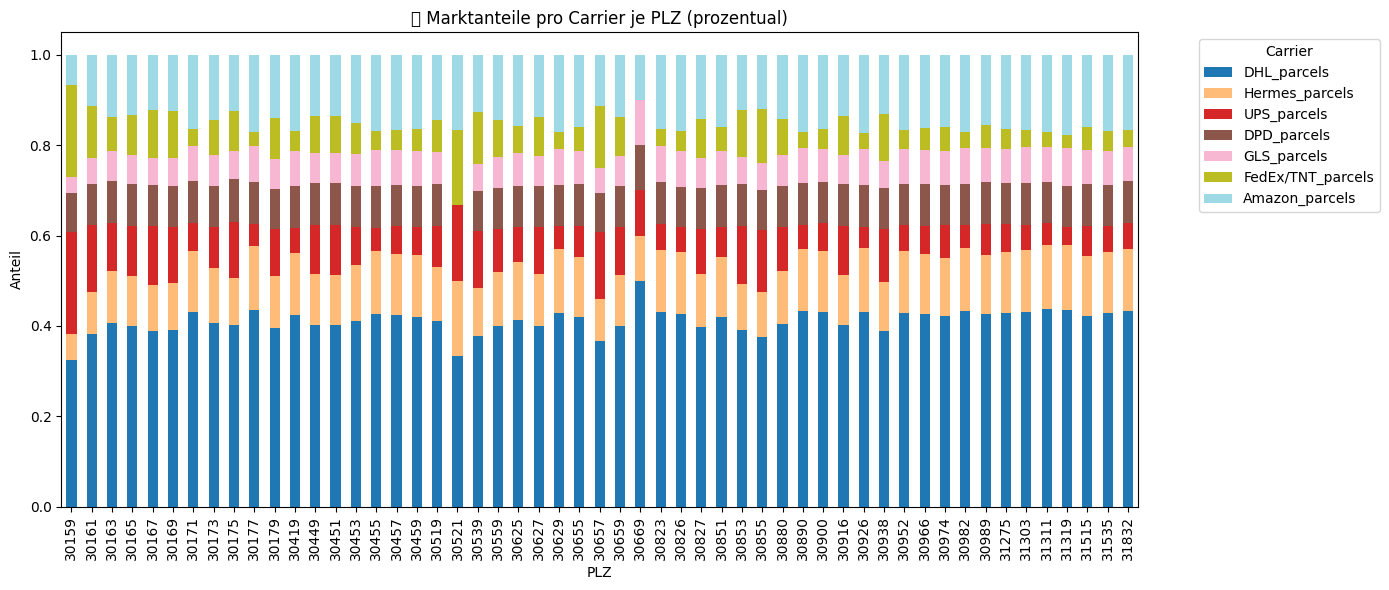

In [310]:
# 1. Bestimme alle Carrier (endet mit "_parcels")
carrier_cols = [col for col in parcel_estimation_per_cell.columns if col.endswith("_parcels") and col != "estimated_parcels"]

# 2. Aggregiere nach PLZ (postal_cod)
df_plot = parcel_estimation_per_cell.groupby("postal_cod")[carrier_cols].sum()

# 3. Normiere je Zeile auf 100% → Marktanteile
df_share = df_plot.div(df_plot.sum(axis=1), axis=0)

# 4. Plotten
df_share.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="tab20")

plt.title("📦 Marktanteile pro Carrier je PLZ (prozentual)")
plt.ylabel("Anteil")
plt.xlabel("PLZ")
plt.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [191]:
df_plot

,DHL_parcels,Hermes_parcels,UPS_parcels,DPD_parcels,GLS_parcels,FedEx/TNT_parcels
postal_cod,,,,,,
30159,2304,785,953,767,364,798
30161,2134,688,930,757,314,778
30163,1690,644,514,457,295,406
30165,1592,635,468,400,295,397
30167,1334,516,433,374,235,366
30169,902,332,363,277,154,321
30171,1325,539,332,318,249,256
30173,1395,564,400,350,256,327
30175,844,278,345,289,126,283


C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_19956\653438573.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


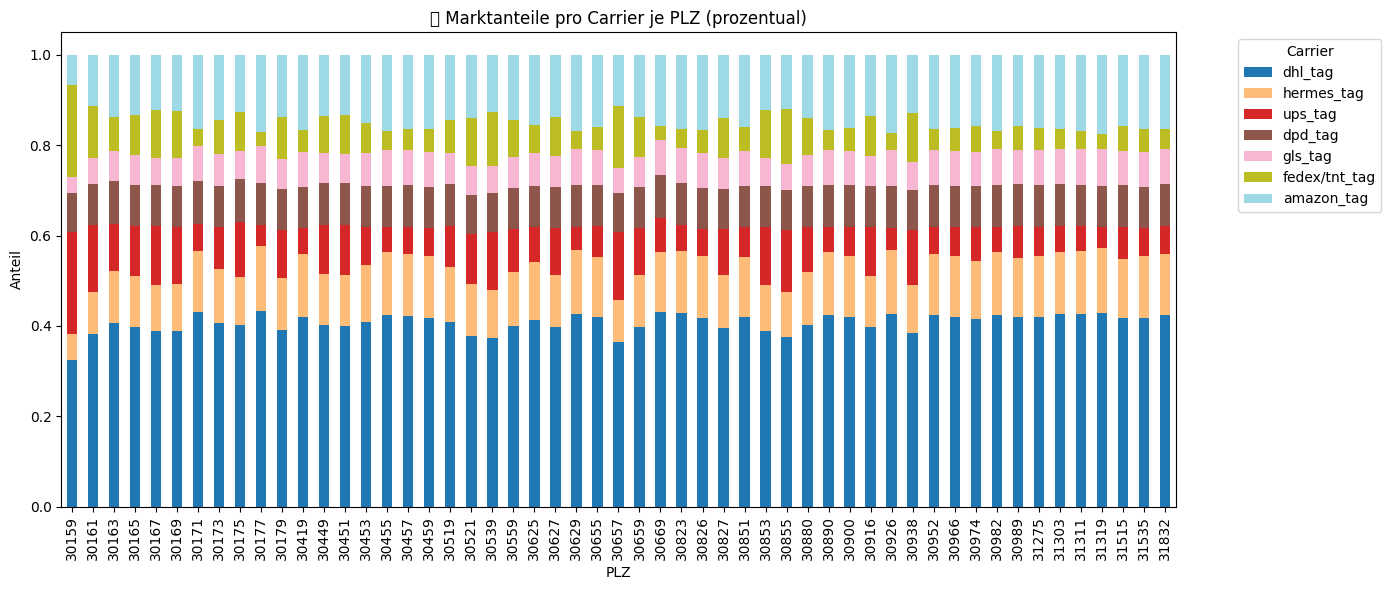

In [147]:
# Set index to PLZ for cleaner plotting
df_plot = df_result.set_index("plz")

# Hole nur die Spalten mit Paketmengen (endet mit "_parcels")
carrier_cols = [col for col in df_result.columns if col.endswith("_tag") and col != "total_tag"]

# Prozentual normalisieren pro Zeile
df_share = df_plot[carrier_cols].div(df_plot[carrier_cols].sum(axis=1), axis=0)

df_share.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="tab20")

plt.title("📊 Marktanteile pro Carrier je PLZ (prozentual)")
plt.ylabel("Anteil")
plt.xlabel("PLZ")
plt.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [83]:
# Nur Carrier-Spalten auswählen
carrier_cols = [col for col in df_result.columns if col.endswith("_tag") and col != "total_tag"]

# Summiere über alle PLZs
global_totals = df_result[carrier_cols].sum()

# Berechne Marktanteile
global_shares = (global_totals / global_totals.sum()).sort_values(ascending=False)

# Ausgabe prüfen
print(global_shares)

dhl_tag          0.402193
amazon_tag       0.144099
hermes_tag       0.119868
ups_tag          0.094886
dpd_tag          0.090779
fedex/tnt_tag    0.079020
gls_tag          0.069154
dtype: float64


In [125]:
df_b2b_by_year


,year,DHL,Hermes,UPS,DPD,GLS,FedEx/TNT,Amazon
0,2014,0.2385,0.0850,0.8800,0.6500,0.2385,0.9500,NaN
1,2015,0.2281,0.0815,0.8800,0.6500,0.2281,0.9500,NaN
2,2016,0.2178,0.0778,0.8800,0.3811,0.2178,0.9500,NaN
3,2017,0.2074,0.0741,0.8800,0.3630,0.2074,0.9500,NaN
4,2018,0.1970,0.0704,0.8800,0.3448,0.1970,0.9500,0.01
5,2019,0.1867,0.0667,0.8800,0.6500,0.1867,0.9500,0.01
6,2020,0.1762,0.0628,0.9161,0.2800,0.1744,0.9500,0.01
7,2021,0.1659,0.0593,0.8800,0.2889,0.1659,0.9500,0.01
8,2022,0.1556,0.0556,0.8800,0.2722,0.1556,0.9500,0.01
9,2023,0.1452,0.0519,0.8800,0.2541,0.1452,0.9500,0.01
